In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from py_pcha import PCHA
from scipy.spatial import ConvexHull, QhullError


In [14]:
try:
    base = Path(__file__).resolve().parent.parent
except NameError:
    base = Path.cwd().parent.parent  # if running interactively inside si_figures/

df_maxs = pd.read_csv(base / 'data' / 'df_maxs.csv',index_col='Unnamed: 0')


t-ratio function and helper functions

In [6]:
def tetrahedron_volume(points):
    p1, p2, p3, p4 = points
    v = np.abs(np.dot(p2 - p1, np.cross(p3 - p1, p4 - p1))) / 6.0
    return v

def xc_to_arcs (XC):
    arcs = []
    arc1 = np.array(XC[:,0]).reshape((3))
    arc2 = np.array(XC[:,1]).reshape((3))
    arc3 = np.array(XC[:,2]).reshape((3))
    arc4 = np.array(XC[:,3]).reshape((3))
    for arc in [arc1,arc2,arc3,arc4] : arcs.append(arc)
    arcs = np.array(arcs)
    return arcs

def find_data_archetypes (data):
    XC, S, C, SSE, varexpl = PCHA(data.transpose(), noc=4, delta=0.1)
    arcs = xc_to_arcs(XC)
    return arcs

def convex_hull_volume(points, joggle_if_needed=False, tol=1e-12):
    """
    Compute the volume of the convex hull of 3D points.

    Parameters
    ----------
    points : (N,3) array_like
        Input points (e.g., shape (531,3)).
    joggle_if_needed : bool, default False
        If True, retries with Qhull option 'QJ' to handle nearly-coplanar data.
    tol : float, default 1e-12
        Tolerance for rank test to detect truly degenerate (<=2D) data.

    Returns
    -------
    float
        Volume of the convex hull (units^3). Returns 0.0 if data are degenerate.
    """
    pts = np.asarray(points, dtype=float)
    if pts.ndim != 2 or pts.shape[1] != 3:
        raise ValueError("`points` must have shape (N, 3).")

    # Quick degeneracy check: colinear/coplanar -> zero volume
    if np.linalg.matrix_rank(pts - pts.mean(axis=0), tol=tol) < 3:
        return 0.0

    try:
        return float(ConvexHull(pts).volume)
    except QhullError:
        if joggle_if_needed:
            # 'QJ' slightly perturbs points to make them full-dimensional
            return float(ConvexHull(pts, qhull_options="QJ").volume)
        # If we get here, treat as degenerate or numerically unstable
        return 0.0

def calc_t_ratio (data):
    arcs = find_data_archetypes(data)
    v_polytop = tetrahedron_volume(arcs)
    v_qhull = convex_hull_volume(data)
    t_ratio = v_polytop / v_qhull
    return t_ratio


In [19]:
len(df_maxs)

531

In [30]:
Ds = ['Temp','Weight','RBC']
D_labels = ['Temperature Change', 'Weight loss','RBC loss']
t_ratios_dict = {}
for D,D_label in zip(Ds,D_labels):
    damage_col_name = f'Max.{D}.Delta.zscore'
    MDI = np.array([df_maxs['Max.Parasitemia.zscore'],df_maxs[damage_col_name],df_maxs['Immune.Intensity.zscore']]).transpose()
    t_ratio = calc_t_ratio(MDI)
    print(f't-ratio for damage {D_label}: {t_ratio:.2f}')
    t_ratios_dict[D] = t_ratio

t-ratio for damage Temperature Change: 0.34
t-ratio for damage Weight loss: 0.34
t-ratio for damage RBC loss: 0.33


Max.Temp.Delta.zscore


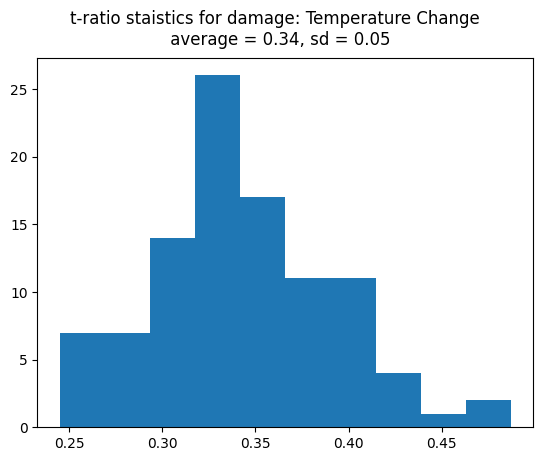

Max.Weight.Delta.zscore


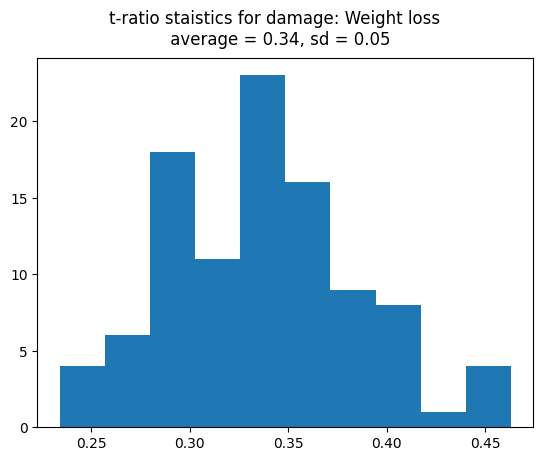

Max.RBC.Delta.zscore


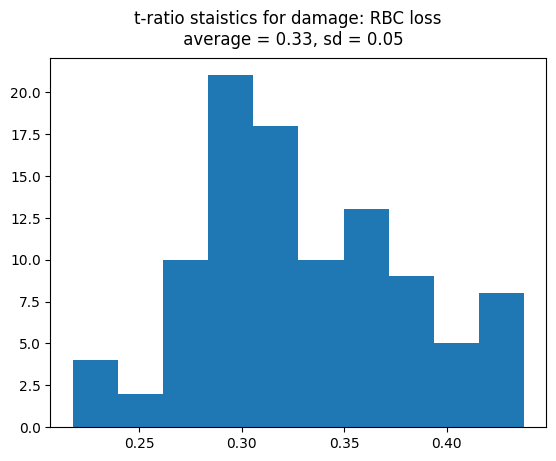

In [ ]:
np.random.seed(7)
for D,D_label in zip(Ds,D_labels):
    bootstrap_num_iterations = 100
    num_sample = 270
    t_ratios = []
    damage_col_name = f'Max.{D}.Delta.zscore'
    print(damage_col_name)
    for j in range(bootstrap_num_iterations):
        df_sample = df_maxs.sample(num_sample)
        MDI = np.array([df_sample['Max.Parasitemia.zscore'],df_sample[damage_col_name],df_sample['Immune.Intensity.zscore']]).transpose()
        t_ratio = calc_t_ratio(MDI)
        t_ratios.append(t_ratio)

    fig,ax = plt.subplots()
    ax.hist(t_ratios)
    fig.suptitle(f't-ratio staistics for damage: {D_label} \n average = {np.mean(t_ratios):.2f}, sd = {np.std(t_ratios):.2f}' )
    plt.show()

The next part calculates the t-ratio statistics for reshuffled points for each damage type

Temperature Change


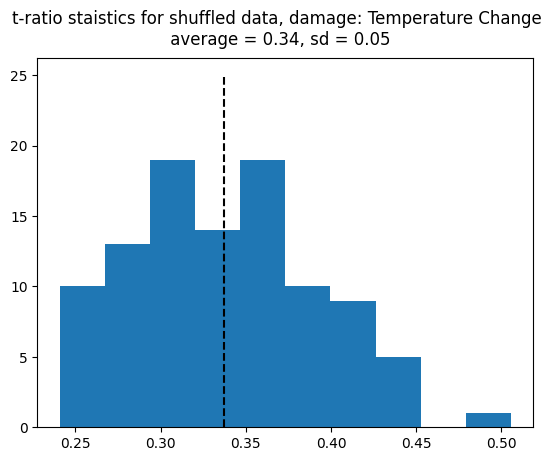

Weight loss


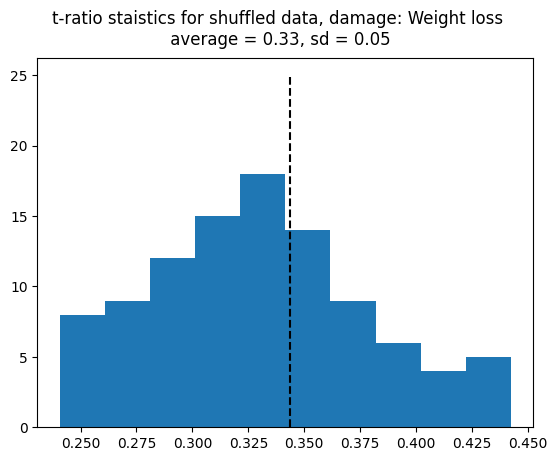

RBC loss


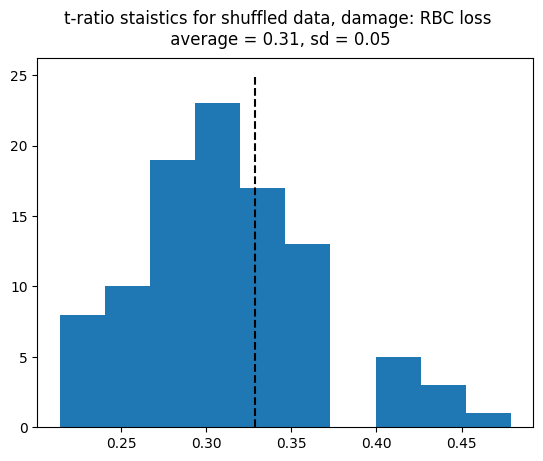

In [31]:
np.random.seed(7)
def sample_from_empirical_marginals(data, size=None, seed=None, plotting="hazen"):
    """
    Draw a new dataset where each column is sampled independently from the
    empirical CDF (marginal) of that column in `data`.

    Parameters
    ----------
    data : (N,3) array_like
        Original dataset (each column is one axis: x, y, z).
    size : int or None
        Number of samples to generate. If None, uses N (i.e., same size).
    seed : int or None
        Random seed for reproducibility.
    plotting : {"hazen","weibull","median","bernard","blom","gringorten","Cunnane"}
        Choice of plotting-position formula for the ECDF (affects tail behavior slightly).
        Default "hazen": (i - 0.5)/N.

    Returns
    -------
    samples : (size,3) ndarray
        New data with each column drawn from the corresponding marginal CDF
        of `data` (independently across columns).
    """
    rng = np.random.default_rng(seed)
    data = np.asarray(data)
    if data.ndim != 2 or data.shape[1] != 3:
        raise ValueError("`data` must have shape (N, 3).")
    N = data.shape[0]
    M = N if size is None else int(size)

    # Choose plotting-position coefficients (p = (i - a)/(N + b))
    # References commonly used in hydrology/statistics.
    schemes = {
        "weibull":  (0.0, 1.0),     # i/(N+1)
        "median":   (1/3, 1/3),     # (i-1/3)/(N+1/3)
        "bernard":  (0.3, 0.4),
        "blom":     (3/8, 1/4),
        "gringorten": (0.44, 0.12),
        "Cunnane":  (0.4, 0.2),
        "hazen":    (0.5, 0.0),     # (i-0.5)/N  (default)
    }
    if plotting not in schemes:
        raise ValueError(f"Unknown plotting scheme '{plotting}'")
    a, b = schemes[plotting]

    def inverse_ecdf_sample(col, m):
        # Sort values and build plotting-position probabilities
        v = np.sort(col)
        # Handle constant columns robustly
        if np.all(v == v[0]):
            return np.full(m, v[0], dtype=float)

        i = np.arange(1, N + 1, dtype=float)
        p = (i - a) / (N + b)
        # Ensure strictly within [0,1] for safe interpolation
        p = np.clip(p, 1e-12, 1 - 1e-12)

        # Draw uniforms and invert the ECDF via linear interpolation
        u = rng.random(m)
        # Guard edges by adding (0, v_min) and (1, v_max)
        p_ext = np.concatenate(([0.0], p, [1.0]))
        v_ext = np.concatenate(([v[0]], v, [v[-1]]))
        return np.interp(u, p_ext, v_ext)

    # Sample each axis independently
    x_new = inverse_ecdf_sample(data[:, 0], M)
    y_new = inverse_ecdf_sample(data[:, 1], M)
    z_new = inverse_ecdf_sample(data[:, 2], M)

    return np.column_stack([x_new, y_new, z_new])

num_reshuffles = 100
for D,D_label in zip(Ds,D_labels):
    t_ratios = []
    damage_col_name = f'Max.{D}.Delta.zscore'
    print(D_label)
    MDI = np.array([df_sample['Max.Parasitemia.zscore'],df_sample[damage_col_name],df_sample['Immune.Intensity.zscore']]).transpose()
    for i in range(num_reshuffles):
        reshuffled_data = sample_from_empirical_marginals(MDI)
        try:
            t_ratio = calc_t_ratio(reshuffled_data)
        except :
            continue
        t_ratios.append(t_ratio)
    fig,ax = plt.subplots()
    ax.hist(t_ratios)
    ax.plot([t_ratios_dict[D]]*50, np.linspace(0,25,50),'--',c = 'black')
    fig.suptitle(f't-ratio staistics for shuffled data, damage: {D_label}\n average = {np.mean(t_ratios):.2f}, sd = {np.std(t_ratios):.2f}')
    plt.show()
    
